## 1. <font color = red> Install and Import the Required Libraries

In [1]:
# Install all the required libraries

!pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 804.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.1/606.1 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.1 MB/s eta 0

In [2]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

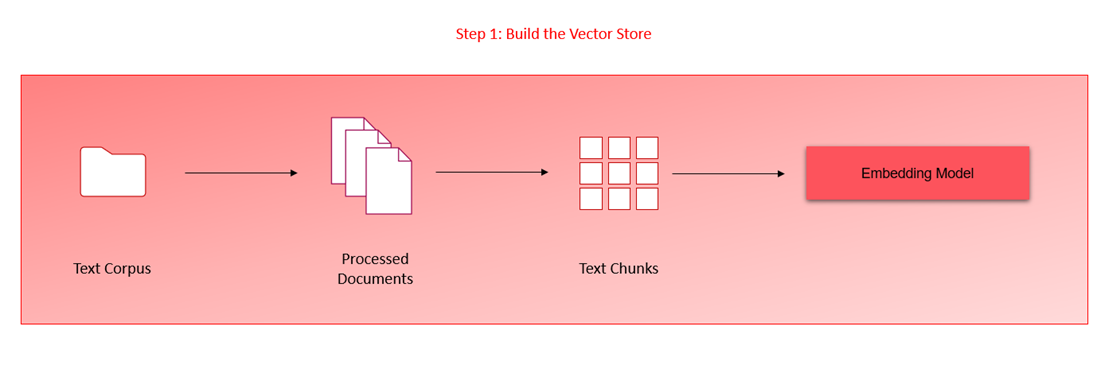

In [4]:
# Define the path of the PDF
single_pdf_path = '/content/drive/MyDrive/AI/IIITB GEN AI/Retrieval_Augmented_Generation/Policy+Documents/HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf'

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [5]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

apart; and
ii. Requiring continuous permanent supplementary oxygen therapy for hypoxemia;
and
iii. Arterial blood gas analysis with partial oxygen pressure of 55mmHg or less
(PaO2 < 55mmHg); and
iv. Dyspnea at rest.
Confirmation by a consultant physician acceptable to the Company of the loss of
independent existence due to Illness or trauma, which has lasted for a minimum
period of 6 months and results in a permanent inability to perform at least three (3) of
the Activities of Daily Living (either with or without the use of mechanical
equipment, special devices or other aids and adaptations in use for disabled persons).
For the purpose of this benefit, the word “permanent”, shall mean beyond the hope of
recovery with current medical knowledge and technology.
Activities of Daily Living are:-
a) Washing: the ability to wash in the bath or shower (including getting into and out
of the bath or shower) or wash satisfactorily by other means.
Loss of
b) Dressing: the ability to put on, take o

In [6]:
# View the table in the page, if any

tables[0]

[['',
  '',
  'apart; and\nii. Requiring continuous permanent supplementary oxygen therapy for hypoxemia;\nand\niii. Arterial blood gas analysis with partial oxygen pressure of 55mmHg or less\n(PaO2 < 55mmHg); and\niv. Dyspnea at rest.'],
 ['11',
  'Loss of\nIndepende\nnt\nExistence',
  'Confirmation by a consultant physician acceptable to the Company of the loss of\nindependent existence due to Illness or trauma, which has lasted for a minimum\nperiod of 6 months and results in a permanent inability to perform at least three (3) of\nthe Activities of Daily Living (either with or without the use of mechanical\nequipment, special devices or other aids and adaptations in use for disabled persons).\nFor the purpose of this benefit, the word “permanent”, shall mean beyond the hope of\nrecovery with current medical knowledge and technology.\nActivities of Daily Living are:-\na) Washing: the ability to wash in the bath or shower (including getting into and out\nof the bath or shower) or wash

#### <font color = red> 2.2 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [7]:
# Define the path where all pdf documents are present

# pdf_path = "/content/drive/My Drive/HelpMate AI Codes/Policy Documents"
pdf_path = "/content/drive/MyDrive/AI/IIITB GEN AI/Retrieval_Augmented_Generation/Policy+Documents"

In [8]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [9]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [10]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing HDFC-Life-Group-Term-Life-Policy.pdf
Finished processing HDFC-Life-Group-Term-Life-Policy.pdf
...Processing HDFC-Surgicare-Plan-101N043V01.pdf
Finished processing HDFC-Surgicare-Plan-101N043V01.pdf
...Processing HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf
Finished processing HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf
...Processing HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
Finished processing HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
...Processing HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf
Finished processing HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf
...Processing HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
Finished processing HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
...Processing HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
Finished processing HDFC-Life-Group-Poorna-Suraksha-101N137V02-

In [11]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [12]:
insurance_pdfs_data

Page No.                                          Page_Text  \
0     Page 1  HDFC Life Group Term Life OF «OWNERNAME» Based...   
1     Page 2  PART A: Covering Letter with Policy Schedule <...   
2     Page 3  Address : Mobile/Landline Number : A1 Free Loo...   
3     Page 4  [["Name of Policy", "HDFC Life Group Term Life...   
4     Page 5  [["Policy No.", ""], ["Name & Address of Polic...   
..       ...                                                ...   
212  Page 27  Annexure IV Definitions of covered Critical Il...   
213  Page 28  6. Alzheimer's Disease - Deterioration or loss...   
214  Page 29  13. Third Degree Burns - There must be third-d...   
215  Page 30   One of the following human organs: heart, lu...   
216  Page 31   Clinical manifestations of anaemia, polyuria...   

                                         Document Name  
0                 HDFC-Life-Group-Term-Life-Policy.pdf  
1                 HDFC-Life-Group-Term-Life-Policy.pdf  
2                 HDFC-Life-Group-Term-Life-Policy.pdf  
3                 HDFC-Life-Group-Term-Life-Policy.pdf  
4                 HDFC-Life-Group-Term-Life-Policy.pdf  
..                                                 ...  
212  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...  
213  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...  
214  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...  
215  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...  
216  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...  

[217 rows x 3 columns]

In [13]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[2]

'Address : Mobile/Landline Number : A1 Free Look Provisions: For the Master Policyholder The Master Policyholder shall have a period of 15 days from the date of receipt of the Master Policy document to review the terms and conditions of this Policy and if the Master Policyholder disagrees with any of the terms and conditions, he/she has the option to return the Master Policy stating the reasons for the cancellation upon which the Company shall refund the Premium paid subject to deduction of a proportionate risk Premium for the period of Insurance Cover in addition to the expenses incurred on medical examination (if any) and the stamp duty charges. All Benefits and rights under this Policy shall immediately stand terminated on the cancellation of the Policy. The Master Policyholder shall have a period of 30 days if the Policy is sourced through Direct Sales# from the date of receipt of the Master Policy document to review the terms and conditions of this Policy and if the Master Policyh

In [14]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [15]:
insurance_pdfs_data

Page No.                                          Page_Text  \
0     Page 1  HDFC Life Group Term Life OF «OWNERNAME» Based...   
1     Page 2  PART A: Covering Letter with Policy Schedule <...   
2     Page 3  Address : Mobile/Landline Number : A1 Free Loo...   
3     Page 4  [["Name of Policy", "HDFC Life Group Term Life...   
4     Page 5  [["Policy No.", ""], ["Name & Address of Polic...   
..       ...                                                ...   
212  Page 27  Annexure IV Definitions of covered Critical Il...   
213  Page 28  6. Alzheimer's Disease - Deterioration or loss...   
214  Page 29  13. Third Degree Burns - There must be third-d...   
215  Page 30   One of the following human organs: heart, lu...   
216  Page 31   Clinical manifestations of anaemia, polyuria...   

                                         Document Name  Text_Length  
0                 HDFC-Life-Group-Term-Life-Policy.pdf           57  
1                 HDFC-Life-Group-Term-Life-Policy.pdf          400  
2                 HDFC-Life-Group-Term-Life-Policy.pdf          618  
3                 HDFC-Life-Group-Term-Life-Policy.pdf           67  
4                 HDFC-Life-Group-Term-Life-Policy.pdf          174  
..                                                 ...          ...  
212  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          582  
213  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          625  
214  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          642  
215  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          586  
216  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          301  

[217 rows x 4 columns]

In [16]:
max(insurance_pdfs_data['Text_Length'])

994

In [17]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

Page No.                                          Page_Text  \
0     Page 1  HDFC Life Group Term Life OF «OWNERNAME» Based...   
1     Page 2  PART A: Covering Letter with Policy Schedule <...   
2     Page 3  Address : Mobile/Landline Number : A1 Free Loo...   
3     Page 4  [["Name of Policy", "HDFC Life Group Term Life...   
4     Page 5  [["Policy No.", ""], ["Name & Address of Polic...   
..       ...                                                ...   
212  Page 27  Annexure IV Definitions of covered Critical Il...   
213  Page 28  6. Alzheimer's Disease - Deterioration or loss...   
214  Page 29  13. Third Degree Burns - There must be third-d...   
215  Page 30   One of the following human organs: heart, lu...   
216  Page 31   Clinical manifestations of anaemia, polyuria...   

                                         Document Name  Text_Length  
0                 HDFC-Life-Group-Term-Life-Policy.pdf           57  
1                 HDFC-Life-Group-Term-Life-Policy.pdf          400  
2                 HDFC-Life-Group-Term-Life-Policy.pdf          618  
3                 HDFC-Life-Group-Term-Life-Policy.pdf           67  
4                 HDFC-Life-Group-Term-Life-Policy.pdf          174  
..                                                 ...          ...  
212  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          582  
213  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          625  
214  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          642  
215  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          586  
216  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          301  

[210 rows x 4 columns]

In [18]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

<ipython-input-18-4493f15e2dc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [19]:
insurance_pdfs_data

Page No.                                          Page_Text  \
0     Page 1  HDFC Life Group Term Life OF «OWNERNAME» Based...   
1     Page 2  PART A: Covering Letter with Policy Schedule <...   
2     Page 3  Address : Mobile/Landline Number : A1 Free Loo...   
3     Page 4  [["Name of Policy", "HDFC Life Group Term Life...   
4     Page 5  [["Policy No.", ""], ["Name & Address of Polic...   
..       ...                                                ...   
212  Page 27  Annexure IV Definitions of covered Critical Il...   
213  Page 28  6. Alzheimer's Disease - Deterioration or loss...   
214  Page 29  13. Third Degree Burns - There must be third-d...   
215  Page 30   One of the following human organs: heart, lu...   
216  Page 31   Clinical manifestations of anaemia, polyuria...   

                                         Document Name  Text_Length  \
0                 HDFC-Life-Group-Term-Life-Policy.pdf           57   
1                 HDFC-Life-Group-Term-Life-Policy.pdf          400   
2                 HDFC-Life-Group-Term-Life-Policy.pdf          618   
3                 HDFC-Life-Group-Term-Life-Policy.pdf           67   
4                 HDFC-Life-Group-Term-Life-Policy.pdf          174   
..                                                 ...          ...   
212  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          582   
213  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          625   
214  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          642   
215  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          586   
216  HDFC-Life-Group-Poorna-Suraksha-101N137V02-Pol...          301   

                                              Metadata  
0    {'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...  
1    {'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...  
2    {'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...  
3    {'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...  
4    {'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...  
..                                                 ...  
212  {'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...  
213  {'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...  
214  {'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...  
215  {'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...  
216  {'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...  

[210 rows x 5 columns]

This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

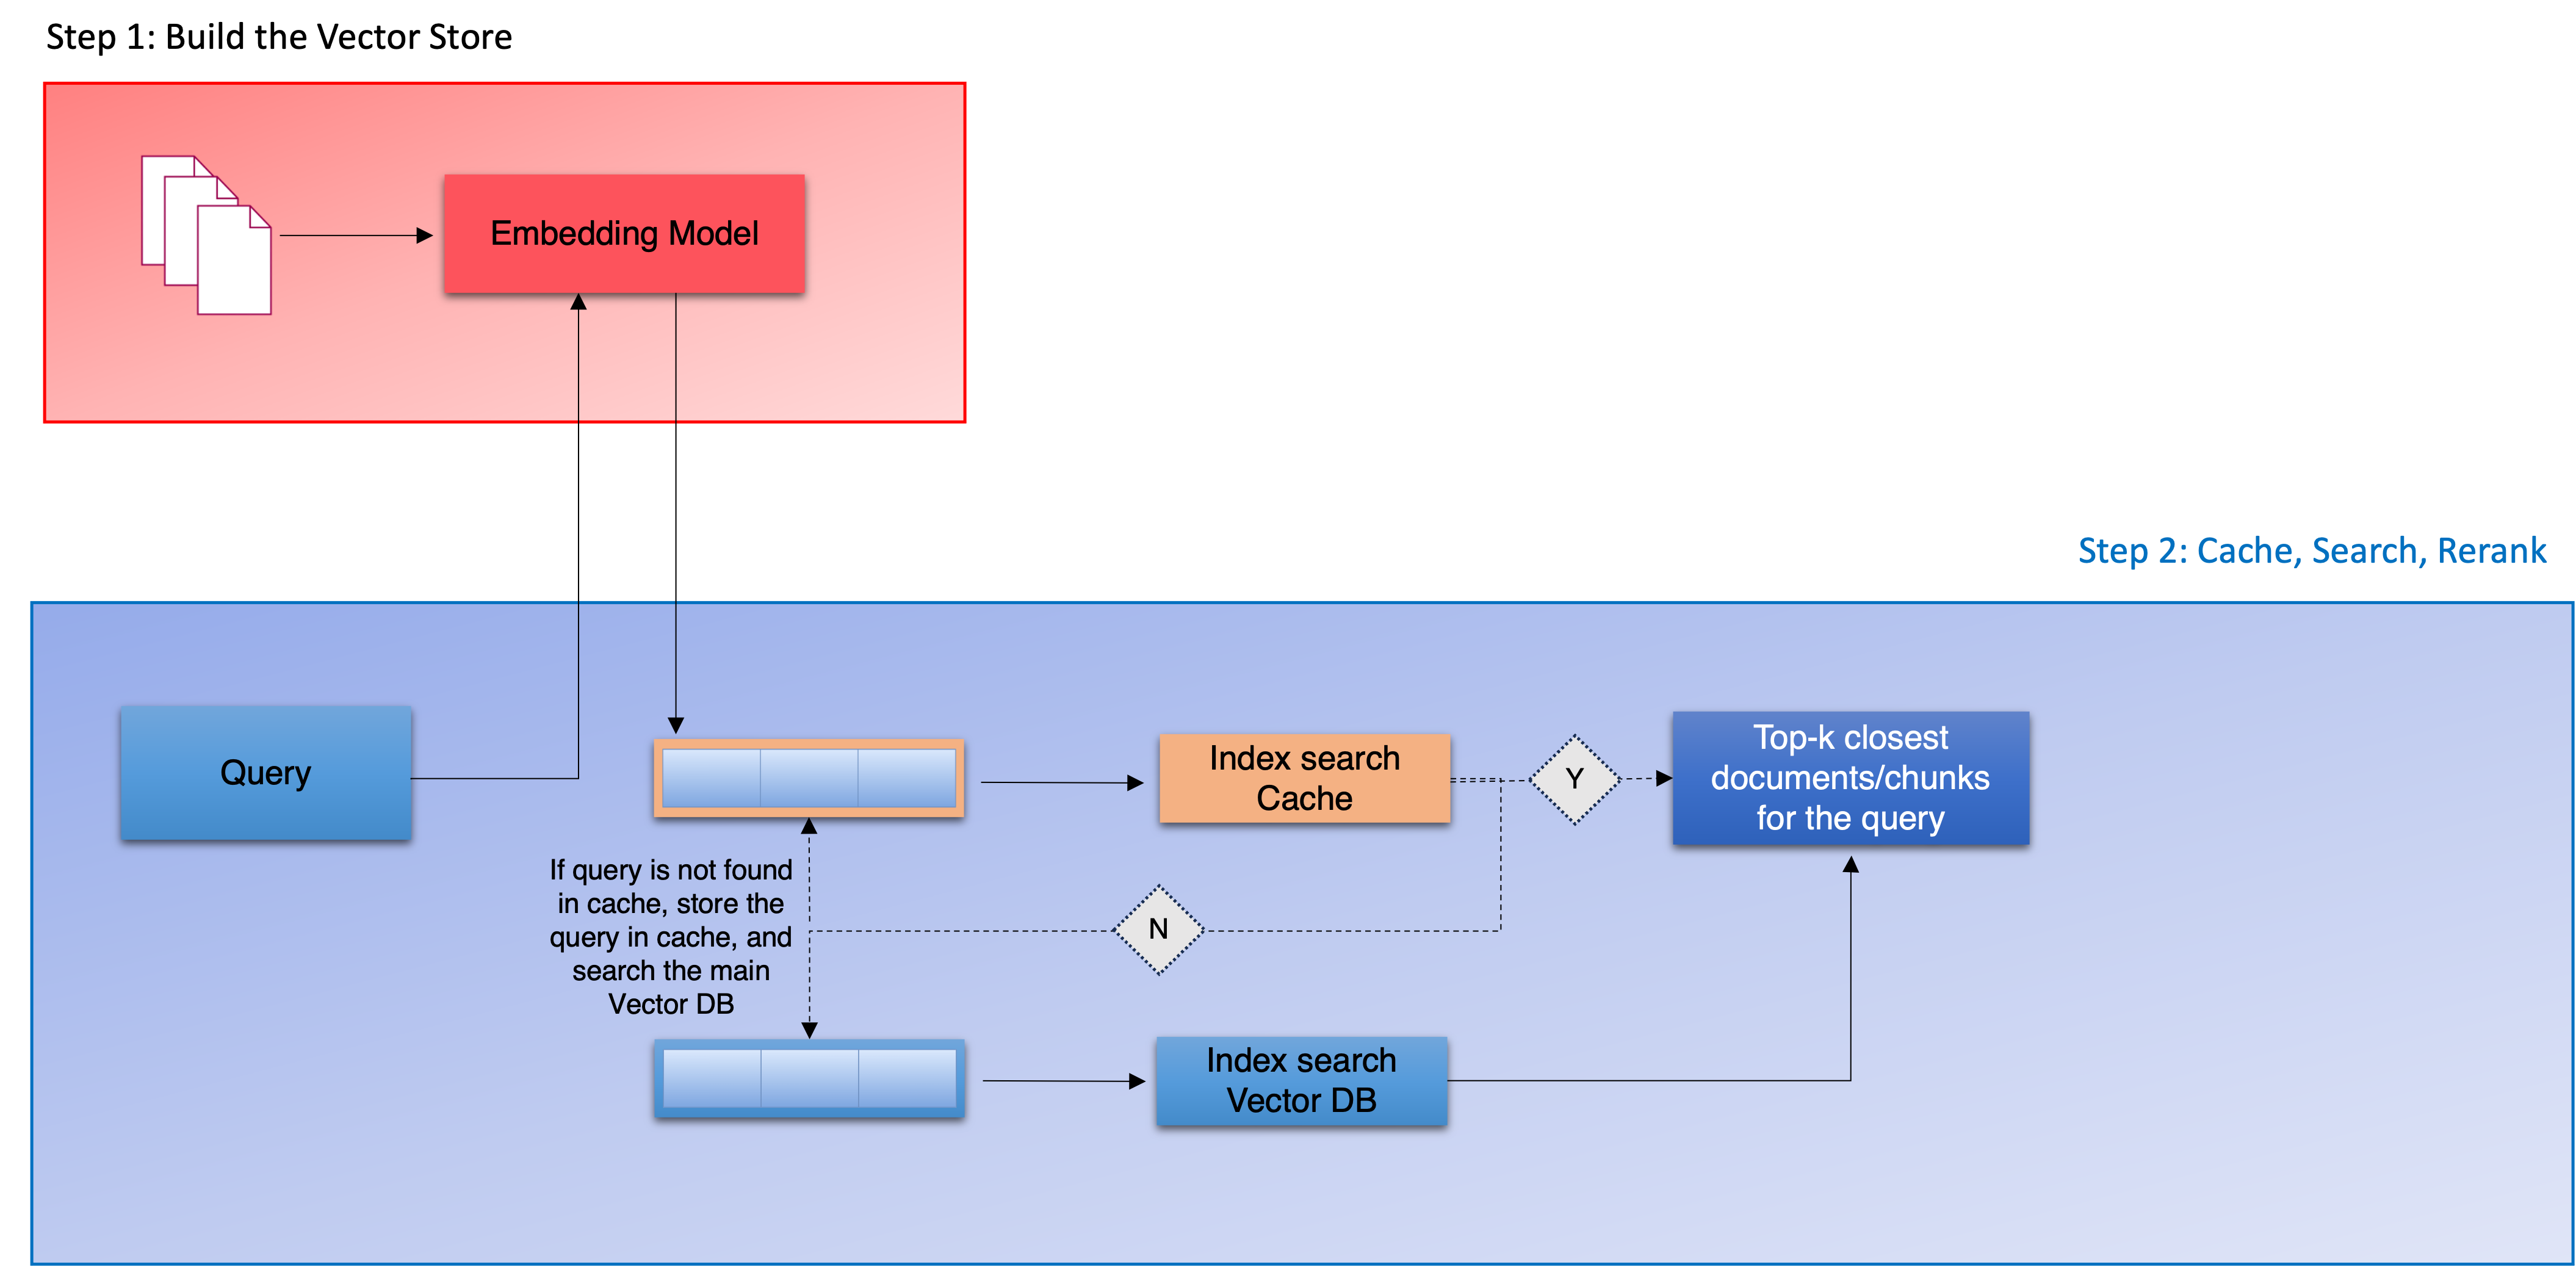

In [20]:
# Set the API key
# filepath = "/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/"

# with open(filepath + "OpenAI_API_Key.txt", "r") as f:
#   openai.api_key = ' '.join(f.readlines())

# Fetch OpenAI API Key from Secrets
from google.colab import userdata
openai.api_key = userdata.get('OPENAI_KEY')

In [21]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [22]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/MyDrive/AI/IIITB GEN AI/Retrieval_Augmented_Generation/ChromaDB_Data'

In [23]:
import chromadb

In [24]:
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [25]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [26]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [27]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [28]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [29]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-0.00734632, -0.01857472, -0.01777943, ..., -0.02009791,
          0.00751481, -0.00894364],
        [-0.01358616,  0.00592487,  0.00712883, ..., -0.01545146,
         -0.01004548, -0.02394366],
        [-0.00602088, -0.00110196,  0.00557263, ...,  0.00400034,
          0.00536888, -0.02711265]]),
 'documents': ['HDFC Life Group Term Life OF «OWNERNAME» Based on the Proposal and the declarations and any statement made or referred to therein, We will pay the Benefits mentioned in this Policy subject to the terms and conditions contained herein << Designation of the Authorised Signatory >> F&U dated 15th October 2022 UIN-101N169V02 P a ge | 0',
  'PART A: Covering Letter with Policy Schedule <dd-mm-yyyy> __________________ __________________ __________________ __________________ __________________ Your HDFC Life <Policy Name> with Policy No. <Policy no.> Dear Mr./Ms.___________________________, We thank you for choosing HDFC Life Insurance 

In [30]:
cache_collection = client.get_or_create_collection(name='Rag_on_Insurance_Cache', embedding_function=embedding_function)

In [31]:
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [32]:
# Read the user query

query = input()

What are accidental death benefits received in a life insurance?


In [33]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [34]:
cache_results

{'ids': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None,
 'metadatas': [[]],
 'distances': [[]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [37]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None or key == 'included':
          continue
        for i in range(10):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [38]:
results_df

Metadatas  \
0  {'Page_No.': 'Page 15', 'Policy_Name': 'HDFC-L...   
1  {'Page_No.': 'Page 6', 'Policy_Name': 'HDFC-Li...   
2  {'Page_No.': 'Page 11', 'Policy_Name': 'HDFC-L...   
3  {'Page_No.': 'Page 13', 'Policy_Name': 'HDFC-L...   
4  {'Page_No.': 'Page 19', 'Policy_Name': 'HDFC-L...   
5  {'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...   
6  {'Page_No.': 'Page 7', 'Policy_Name': 'HDFC-Li...   
7  {'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...   
8  {'Page_No.': 'Page 23', 'Policy_Name': 'HDFC-L...   
9  {'Page_No.': 'Page 4', 'Policy_Name': 'HDFC-Li...   

                                           Documents  Distances  IDs  
0  Note: For the purpose of waiting period, Date ...   0.271194  193  
1  PART C Product Core Benefits BENEFITS PAYABLE ...   0.303997  119  
2  PART C PRODUCT CORE BENEFITS BENEFITS PAYABLE ...   0.310280   10  
3  HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...   0.311560  164  
4  (i) Death Certificate, in original, issued by ...   0.318137  132  
5  HDFC Life Smart Pension Plan 101L164V02 – Term...   0.320174   84  
6  Part C 1. Benefits: (1) Benefits on Death or d...   0.321102  185  
7  [["21. Progressive\nScleroderma", "22. Muscula...   0.328731  186  
8  HDFC Life Smart Pension Plan 101L164V02 – Term...   0.331040   99  
9  Part B Definitions The following capitalized t...   0.332721  182

## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

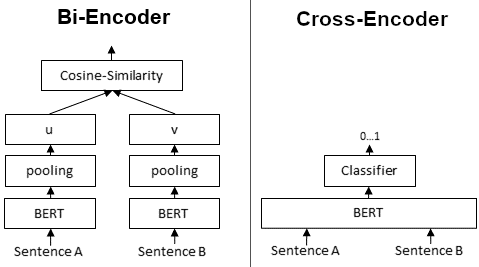

<br>

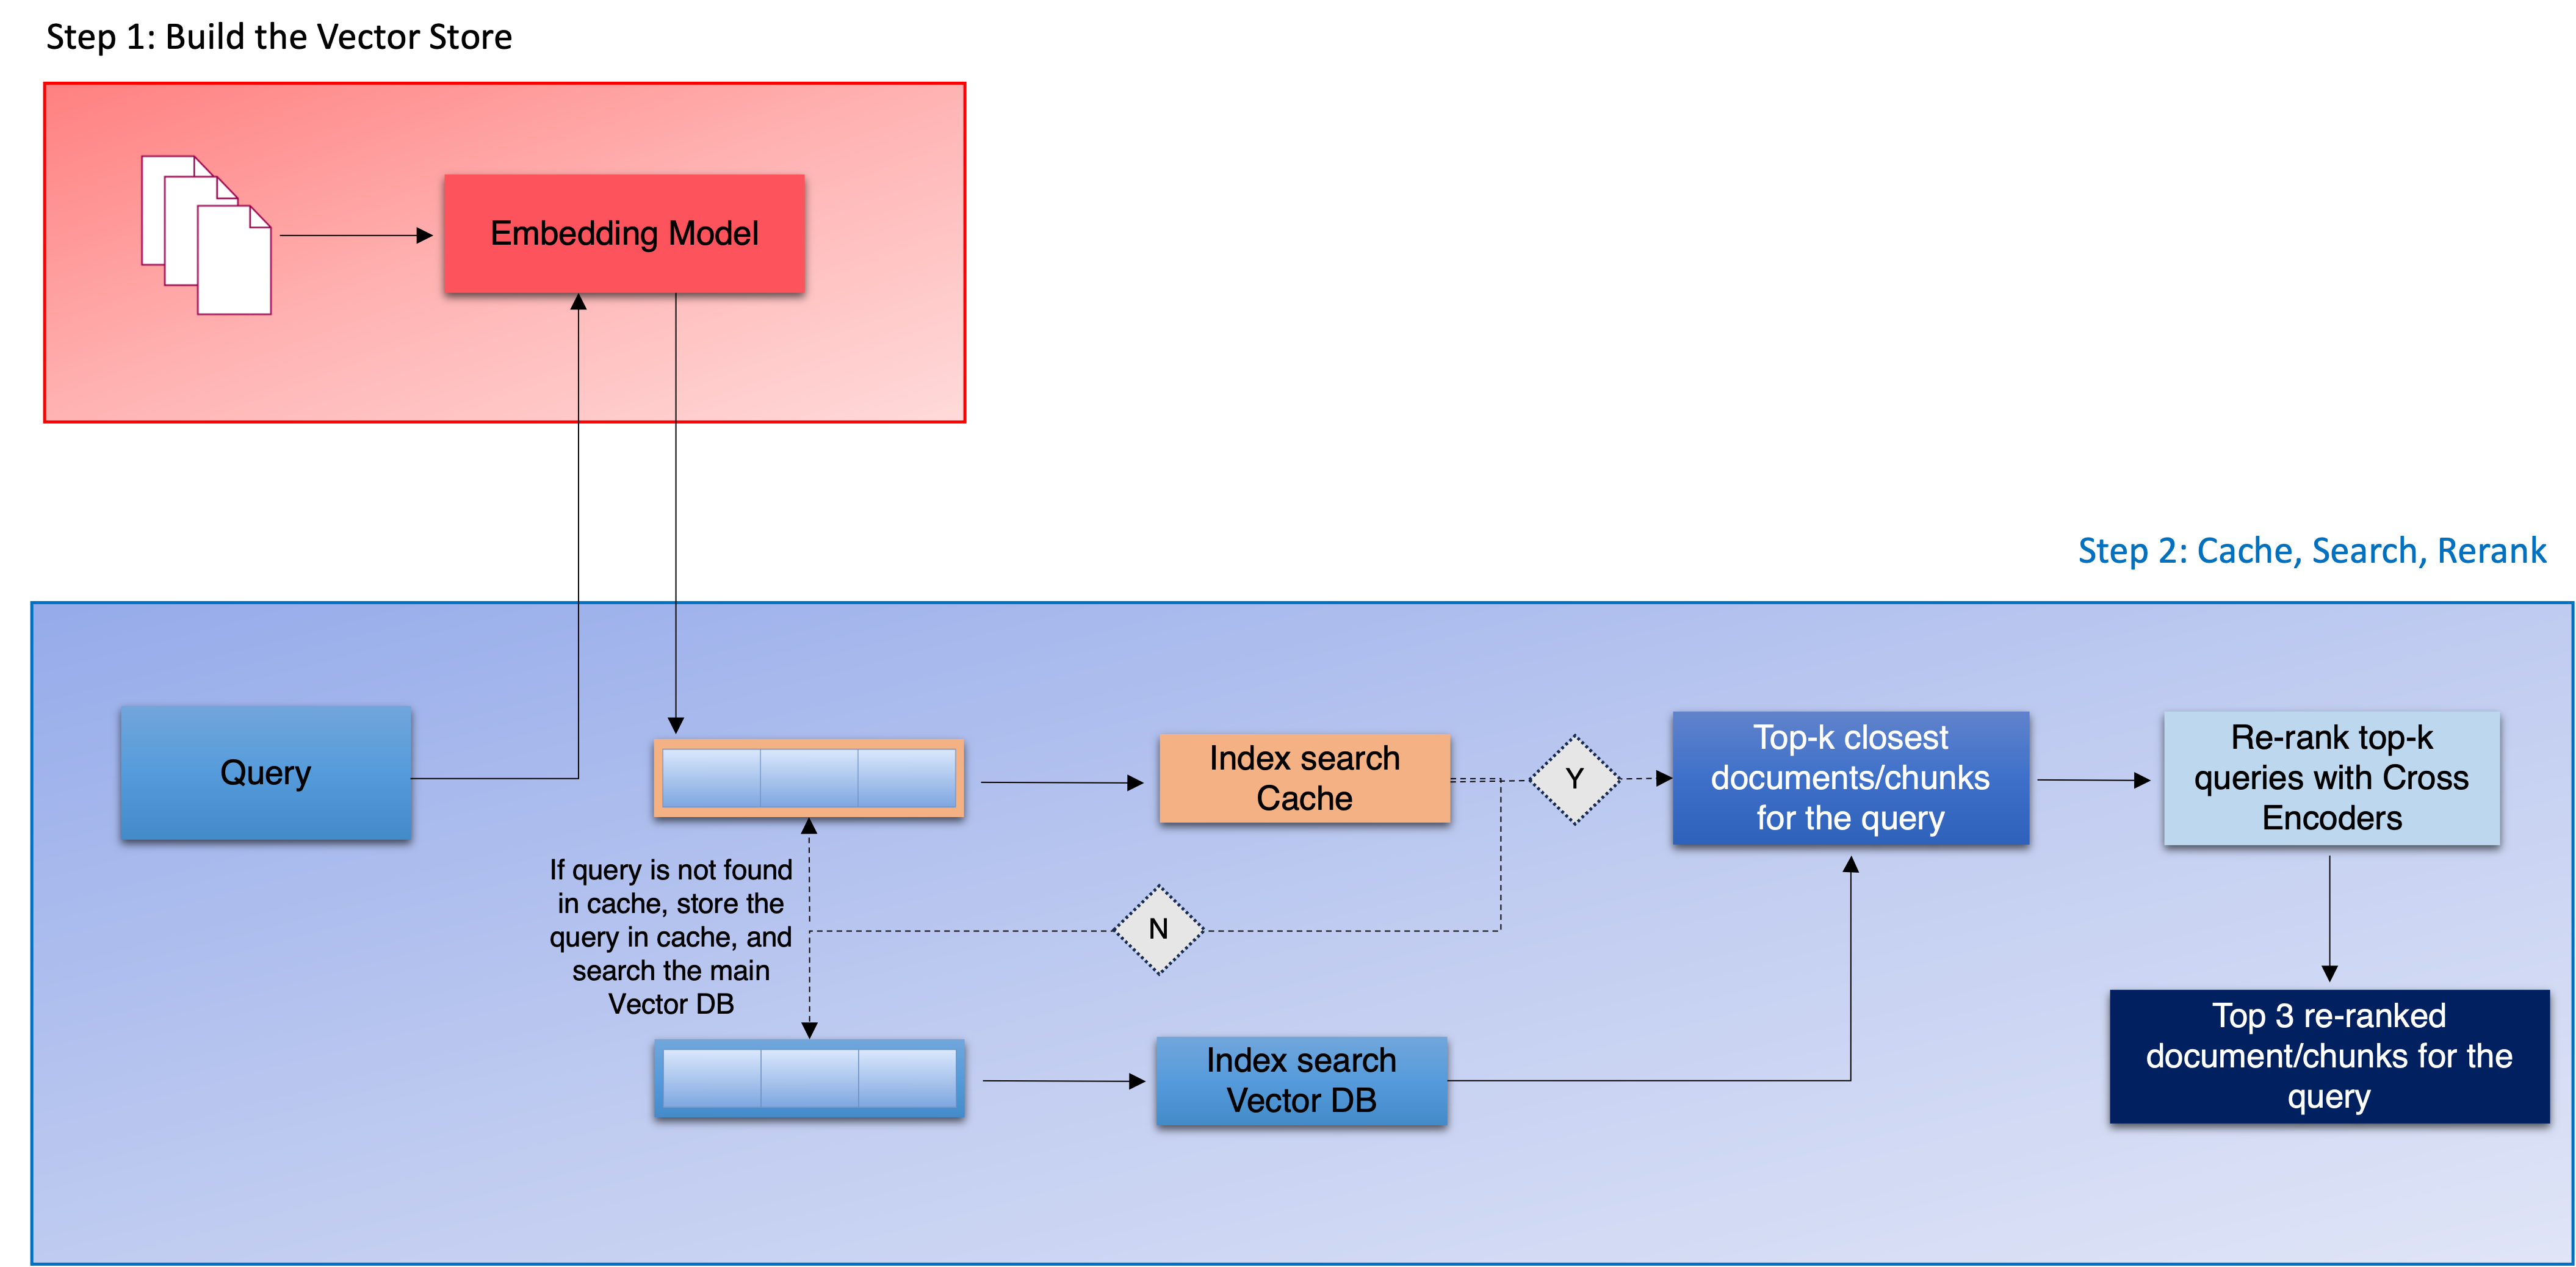

In [39]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [40]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [41]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [42]:
scores

array([  3.8467617, -11.252879 ], dtype=float32)

In [43]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [44]:
cross_rerank_scores

array([ 4.474421 , -2.3336039,  0.0961164, -1.9122488, -1.8544921,
       -3.4309516,  1.9831707, -4.114181 , -1.6488134,  1.8011318],
      dtype=float32)

In [45]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [46]:
results_df

Metadatas  \
0  {'Page_No.': 'Page 15', 'Policy_Name': 'HDFC-L...   
1  {'Page_No.': 'Page 6', 'Policy_Name': 'HDFC-Li...   
2  {'Page_No.': 'Page 11', 'Policy_Name': 'HDFC-L...   
3  {'Page_No.': 'Page 13', 'Policy_Name': 'HDFC-L...   
4  {'Page_No.': 'Page 19', 'Policy_Name': 'HDFC-L...   
5  {'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...   
6  {'Page_No.': 'Page 7', 'Policy_Name': 'HDFC-Li...   
7  {'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...   
8  {'Page_No.': 'Page 23', 'Policy_Name': 'HDFC-L...   
9  {'Page_No.': 'Page 4', 'Policy_Name': 'HDFC-Li...   

                                           Documents  Distances  IDs  \
0  Note: For the purpose of waiting period, Date ...   0.271194  193   
1  PART C Product Core Benefits BENEFITS PAYABLE ...   0.303997  119   
2  PART C PRODUCT CORE BENEFITS BENEFITS PAYABLE ...   0.310280   10   
3  HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...   0.311560  164   
4  (i) Death Certificate, in original, issued by ...   0.318137  132   
5  HDFC Life Smart Pension Plan 101L164V02 – Term...   0.320174   84   
6  Part C 1. Benefits: (1) Benefits on Death or d...   0.321102  185   
7  [["21. Progressive\nScleroderma", "22. Muscula...   0.328731  186   
8  HDFC Life Smart Pension Plan 101L164V02 – Term...   0.331040   99   
9  Part B Definitions The following capitalized t...   0.332721  182   

   Reranked_scores  
0         4.474421  
1        -2.333604  
2         0.096116  
3        -1.912249  
4        -1.854492  
5        -3.430952  
6         1.983171  
7        -4.114181  
8        -1.648813  
9         1.801132

In [47]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

Metadatas  \
0  {'Page_No.': 'Page 15', 'Policy_Name': 'HDFC-L...   
1  {'Page_No.': 'Page 6', 'Policy_Name': 'HDFC-Li...   
2  {'Page_No.': 'Page 11', 'Policy_Name': 'HDFC-L...   

                                           Documents  Distances  IDs  \
0  Note: For the purpose of waiting period, Date ...   0.271194  193   
1  PART C Product Core Benefits BENEFITS PAYABLE ...   0.303997  119   
2  PART C PRODUCT CORE BENEFITS BENEFITS PAYABLE ...   0.310280   10   

   Reranked_scores  
0         4.474421  
1        -2.333604  
2         0.096116

In [48]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

Metadatas  \
0  {'Page_No.': 'Page 15', 'Policy_Name': 'HDFC-L...   
6  {'Page_No.': 'Page 7', 'Policy_Name': 'HDFC-Li...   
9  {'Page_No.': 'Page 4', 'Policy_Name': 'HDFC-Li...   

                                           Documents  Distances  IDs  \
0  Note: For the purpose of waiting period, Date ...   0.271194  193   
6  Part C 1. Benefits: (1) Benefits on Death or d...   0.321102  185   
9  Part B Definitions The following capitalized t...   0.332721  182   

   Reranked_scores  
0         4.474421  
6         1.983171  
9         1.801132

In [49]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [50]:
top_3_RAG

Documents  \
0  Note: For the purpose of waiting period, Date ...   
6  Part C 1. Benefits: (1) Benefits on Death or d...   
9  Part B Definitions The following capitalized t...   

                                           Metadatas  
0  {'Page_No.': 'Page 15', 'Policy_Name': 'HDFC-L...  
6  {'Page_No.': 'Page 7', 'Policy_Name': 'HDFC-Li...  
9  {'Page_No.': 'Page 4', 'Policy_Name': 'HDFC-Li...

## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

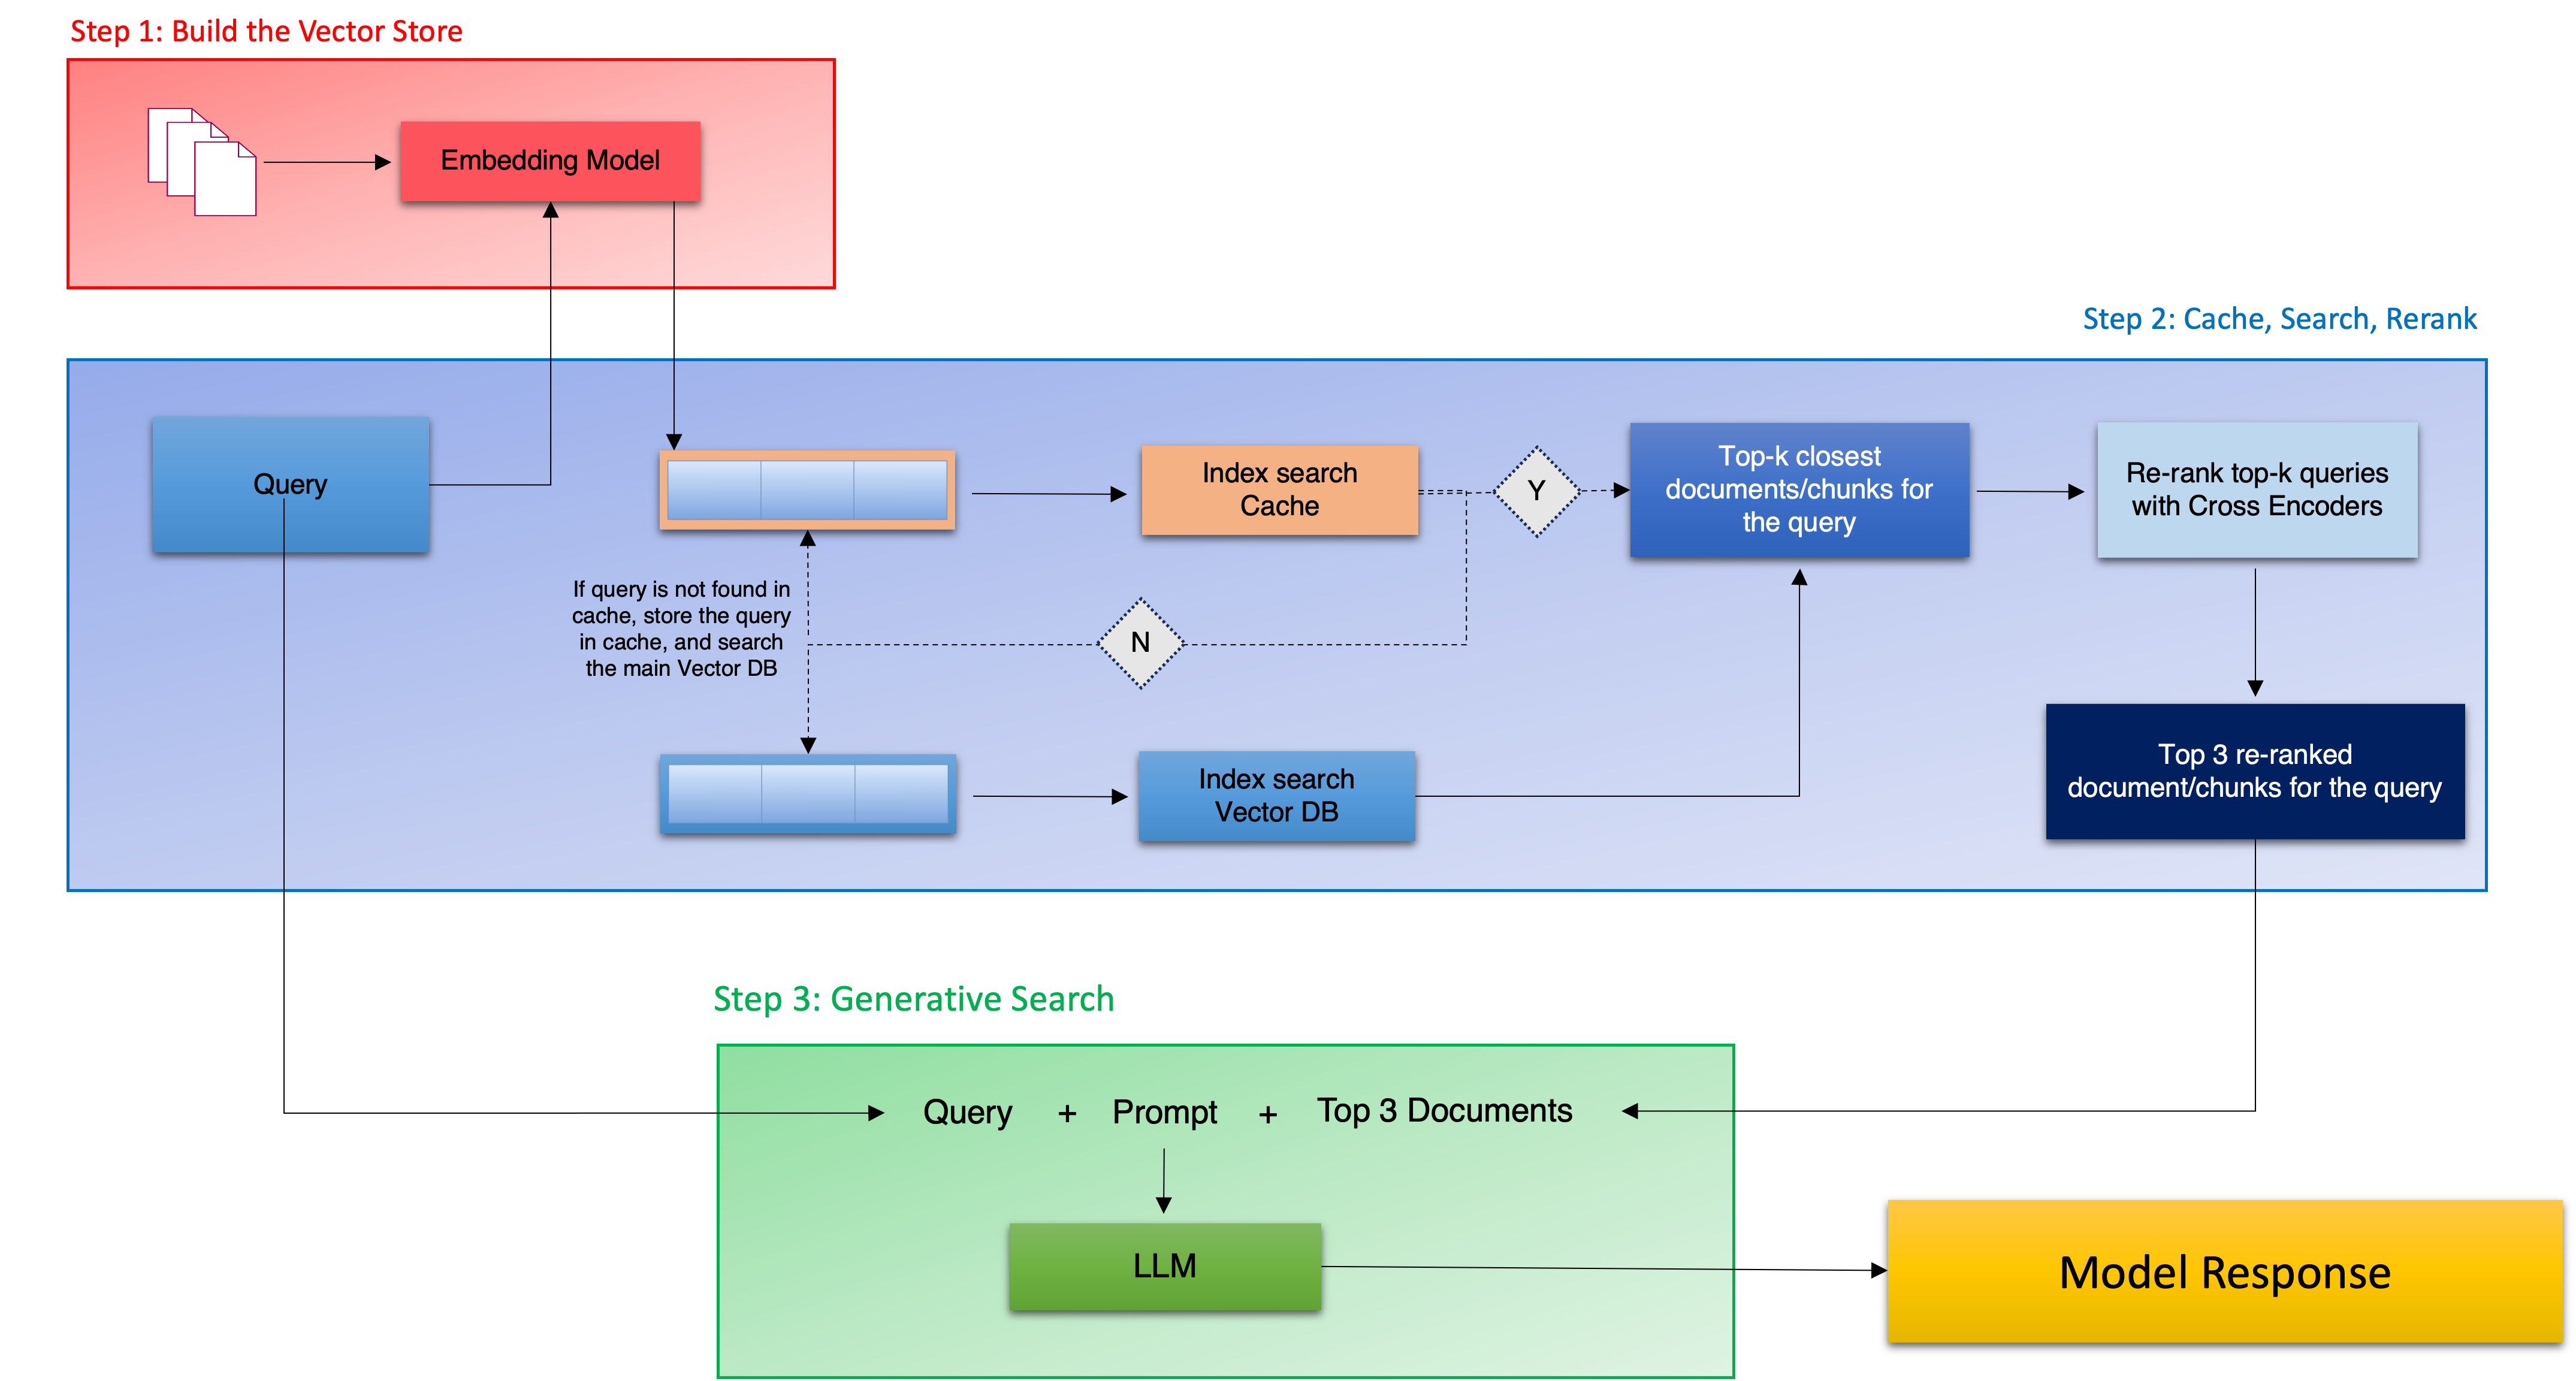

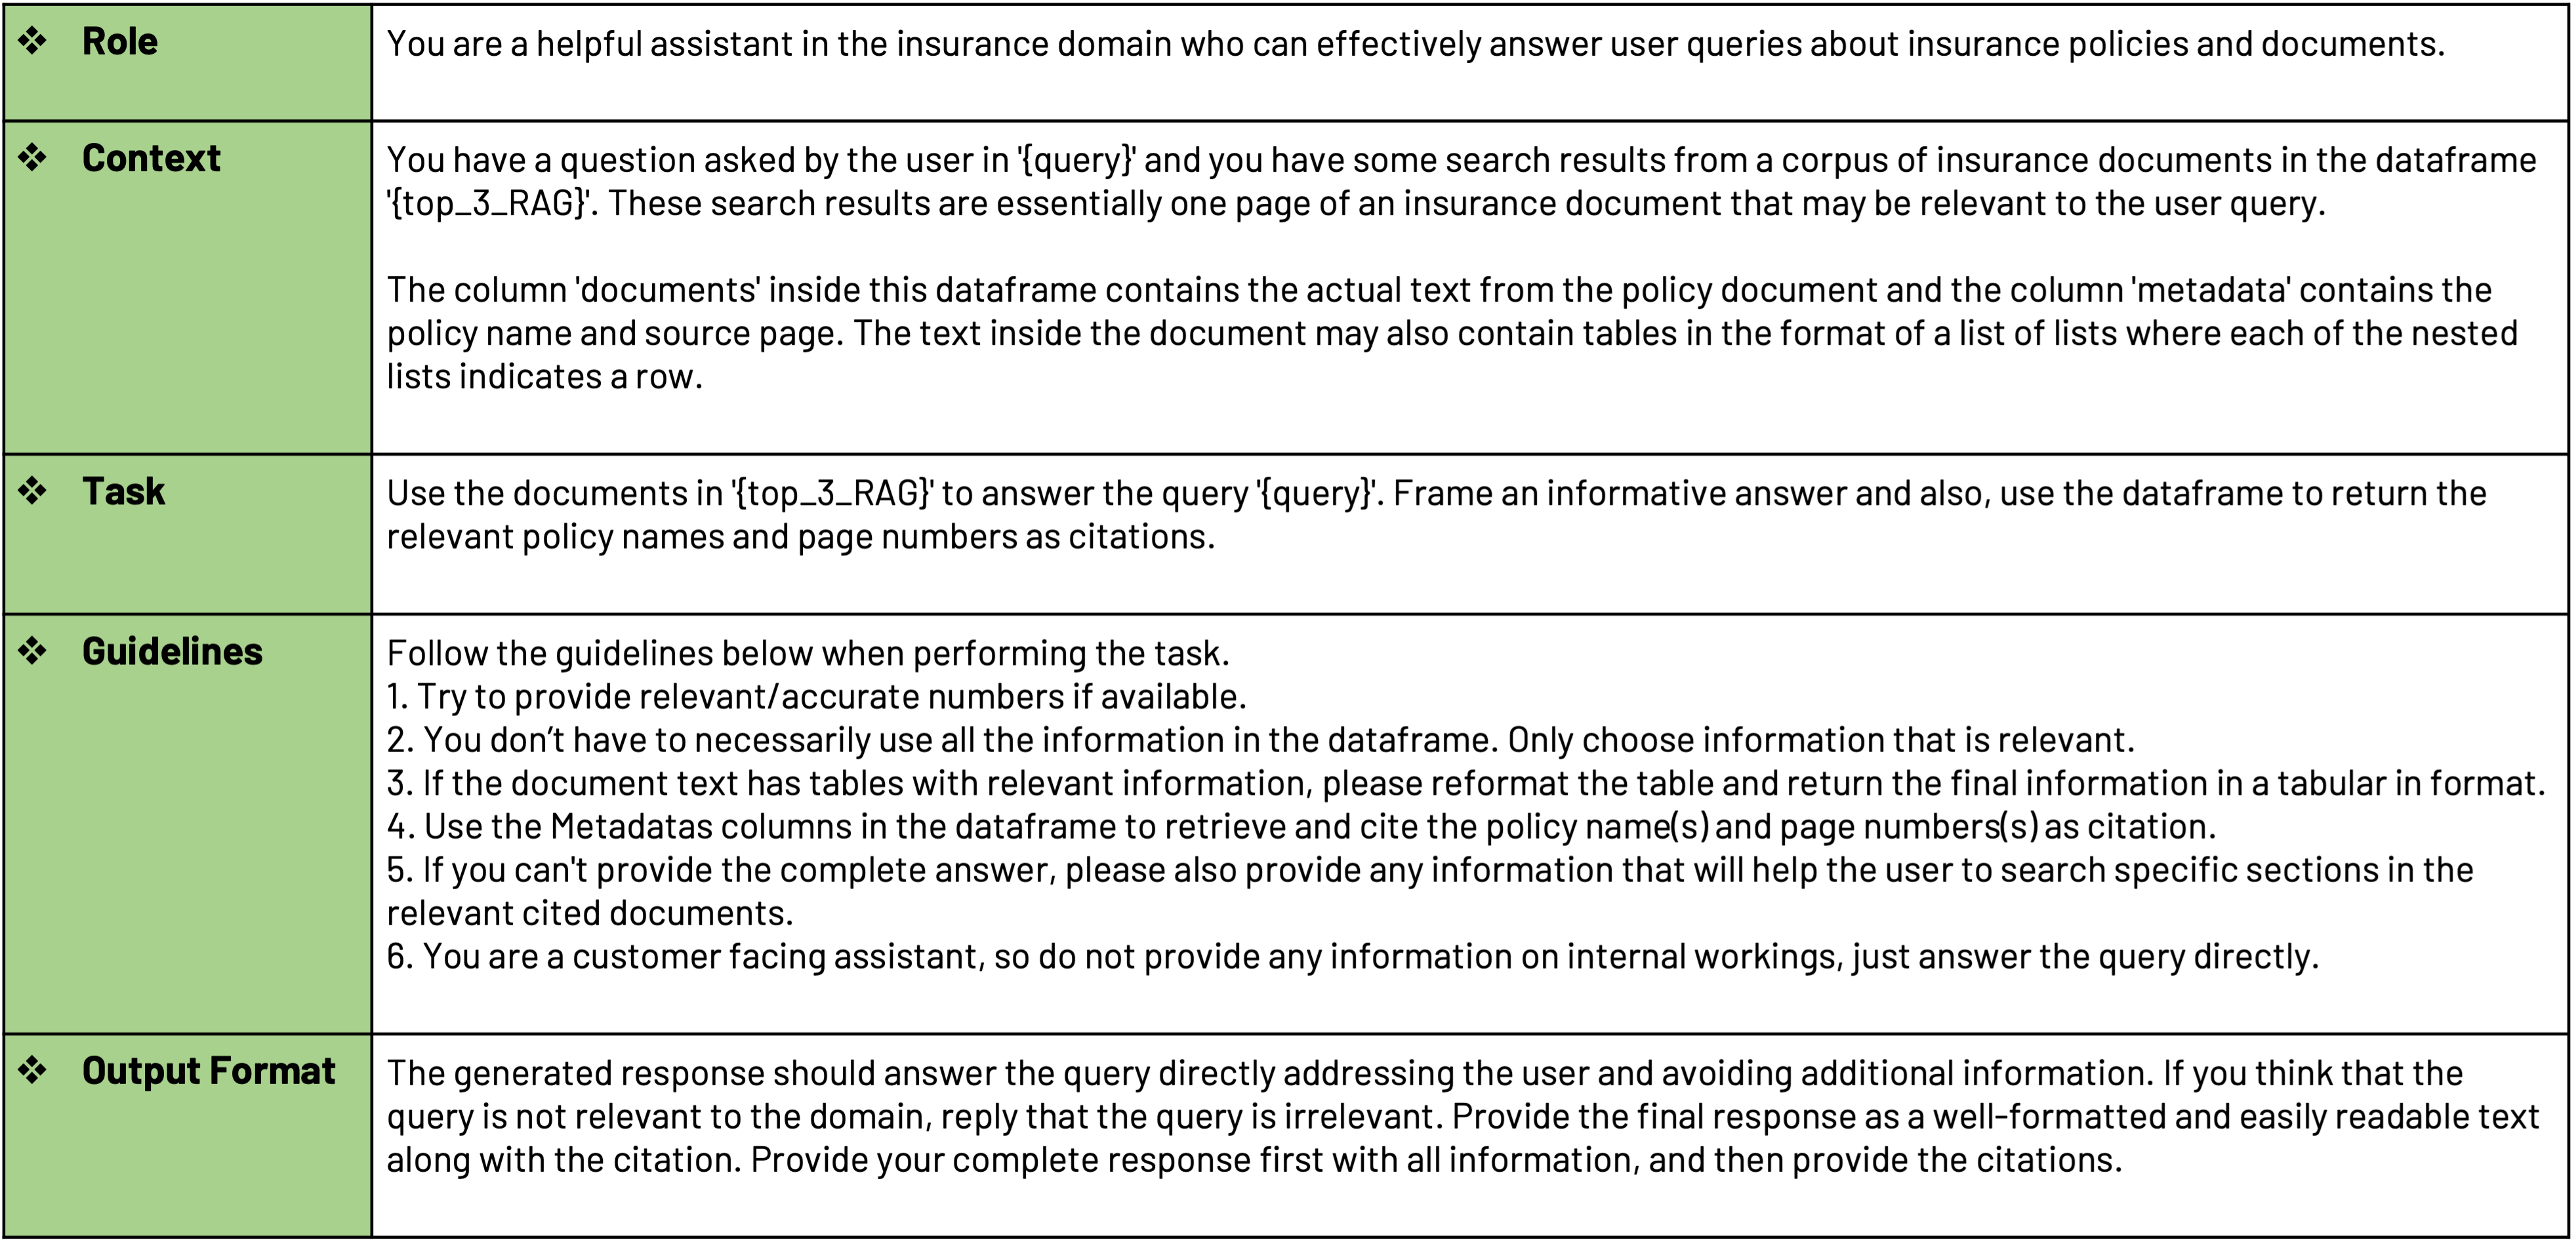

In [51]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [54]:
# Generate the response

response = generate_response(query, top_3_RAG)

In [55]:
# Print the response

print("\n".join(response))

Accidental death benefits received in a life insurance policy typically refer to additional benefits paid out if the insured person dies due to an accident. These benefits are usually in addition to the base death benefit provided by the life insurance policy. The specifics of accidental death benefits can vary depending on the insurance company and policy terms.

Based on the provided insurance document snippets:

- **Policy Name**: HDFC-Life Insurance Policy
- **Page Numbers**: Page 7, Page 15

**Accidental Death Benefits Explanation**:
The excerpt from the policy document contains information related to benefits on death, but it does not explicitly specify details about accidental death benefits. To find specific details about accidental death benefits, you may refer to the benefits section of the policy document and look for clauses or sections that mention accidental death coverage.

In case of non-applicability or absence of information, you may need to refer to a more detailed s